In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sasmodels.core import load_model
from sasdata.dataloader.loader import Loader
from sasmodels.direct_model import DirectModel
import os, shutil, json, glob, pdb

In [22]:
DATA_DIR = '/Users/pozzolabadmin/Documents/codebase/hyak_results/micelles_omiecs/results_SQ_sph_V1/'

In [23]:
# Following are most likely spherical micelles with a PHFBA core and PDEGEEA corona
SI = pd.read_csv('./EXPTDATA_V2/sample_info_OMIECS.csv')

def load_data_from_file(fname, use_trim=False):
    flag = SI["Filename"]=='%s.sub'%fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load('./EXPTDATA_V2/inco_bg_sub/%s.sub'%fname)[0]
    if not use_trim:
        data.qmin = min(data.x)
        data.qmax = max(data.x)
    else:
        # data.qmin = data.x[metadata['lowq_trim']]
        data.qmin = min(data.x)
        data.qmax = data.x[-metadata['Highq_trim']]
        
    return data, metadata

In [24]:
def get_fitted_values(fname):
    with open(DATA_DIR+'%s.json'%fname) as f:
        params = json.load(f)
    
    data, metadata = load_data_from_file(fname, use_trim=True)

    return data, metadata, params

In [25]:
from sasmodels.data import Data1D 
from sasmodels.mixture import *

def plot(fname):
    loaded_data, metadata, params = get_fitted_values(fname)
    min_max_mask = (loaded_data.x >= loaded_data.qmin) & (loaded_data.x <= loaded_data.qmax)
    data = Data1D(x =loaded_data.x[min_max_mask],
                  y = loaded_data.y[min_max_mask],
                  dx = loaded_data.dx[min_max_mask],
                  dy = loaded_data.dy[min_max_mask]
                  )
    
    units = ['Å^3','Å^3', '1e-6 Å^-2', '1e-6 Å^-2', '1e-6 Å^-2', 
             'Å', '', 'Å', '', '', '', '']
    print_keys = ['B_v_core', 'B_v_corona', 'B_sld_solvent', 'B_sld_core', 'B_sld_corona', 
                  'B_radius_core', 'B_radius_core_pd', 'B_rg', 'B_rg_pd', 'B_d_penetration', 'B_n_aggreg' ,'B_scale'
                  ]
    print_vals =  [params[key] for key in print_keys]
    col_1 = np.asarray(['%.2E'%val for val in list(print_vals)])
    col_2 = np.asarray(units)
    cellText = np.vstack((col_1, col_2)).T

    fig, axs = plt.subplots(1,4, figsize=(4*4, 4))
    axs[0].axis('off')
    axs[0].axis('tight')
    axs[0].table(cellText=cellText, rowLabels=list(print_keys), 
            colLabels=['Value', 'Units'], loc='center')
    axs[1].table(cellText=metadata.values.squeeze().reshape(22,1), 
                rowLabels=metadata.columns.values, 
                loc='center'
                )
    axs[1].axis('off')
    axs[1].axis('tight')
    ax = axs[2]
    ax.scatter(loaded_data.x, loaded_data.y, s=10, label='True')

    # Spherical micelle in sasmodels
    hardsphere = load_model("hardsphere")
    sas_model = load_model("../models/spherical_micelle.py")
    model_info = make_mixture_info([hardsphere.info, sas_model.info], operation="+")
    model = MixtureModel(model_info, [hardsphere, sas_model])
    model = DirectModel(data, model)
    Iq_fitted = model(**params)  
    ax.plot(data.x, Iq_fitted, label='predicted', color='tab:orange')
    ax.set_xlabel('q')
    ax.set_ylabel('I(q)')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Fitted curve')

    residuals = (Iq_fitted - data.y) # / data.dy
    nllf = 0.5 * np.sum(residuals**2)
    axs[3].scatter(data.x, residuals, s=10)
    axs[3].set_title('nllf : %.2e'%nllf)
    axs[3].set_xlabel('q')
    axs[3].set_ylabel('residuals')
    axs[3].set_xscale('log')
    axs[3].set_xlim([min(loaded_data.x), max(loaded_data.x)])

    for i in [2,3]:
        axs[i].axvline(x=loaded_data.qmin, color='k')
        axs[i].axvline(x=loaded_data.qmax, color='k') 

    fig.subplots_adjust(left=0.2, top=0.8, wspace=0.6)

    return 


Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F25_10dTHF75.sub'


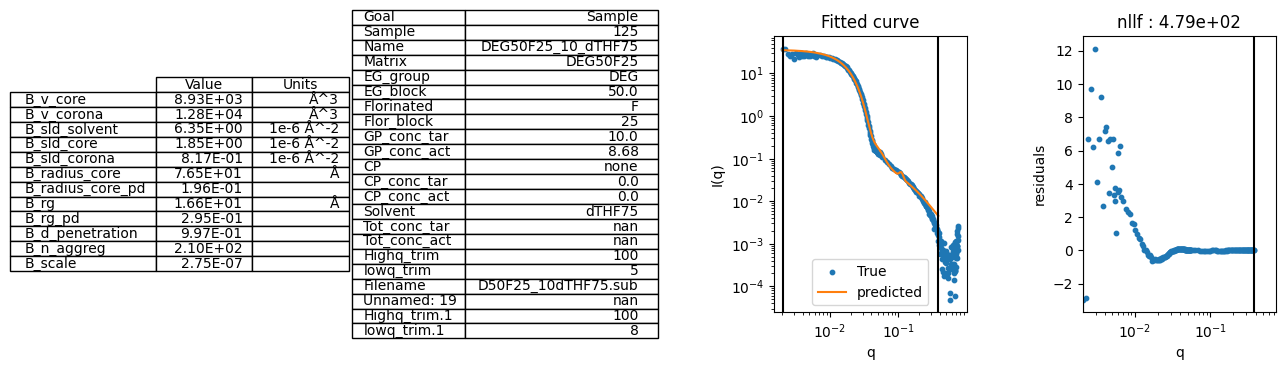

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F25b_10dTHF75.sub'


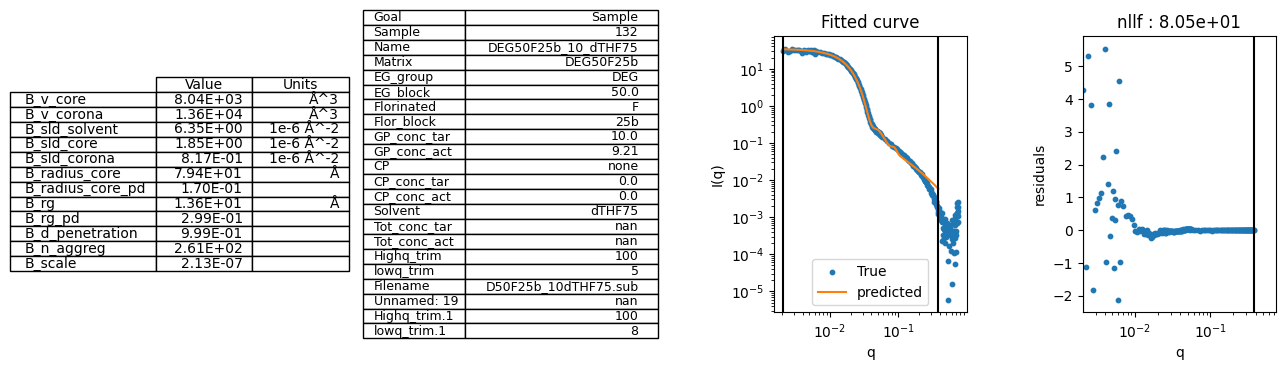

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F25b_10dTol.sub'


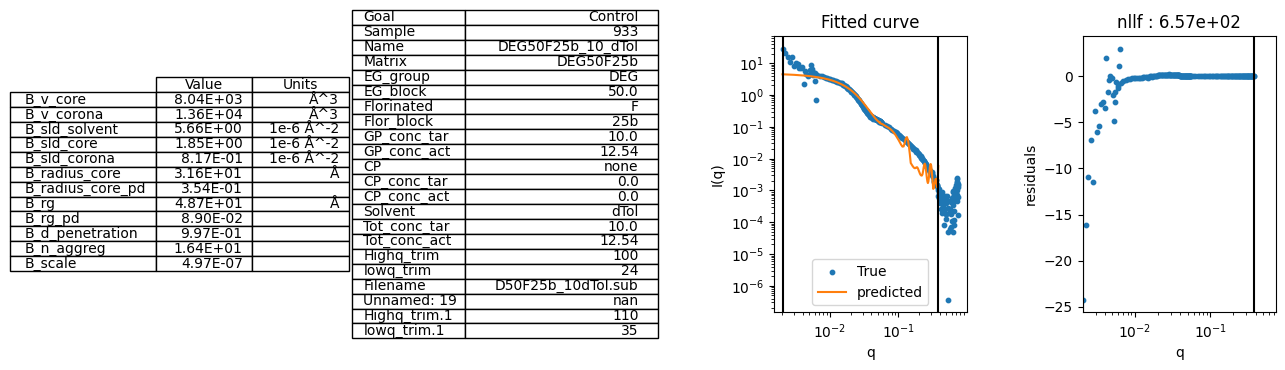

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F50_10dTHF50.sub'


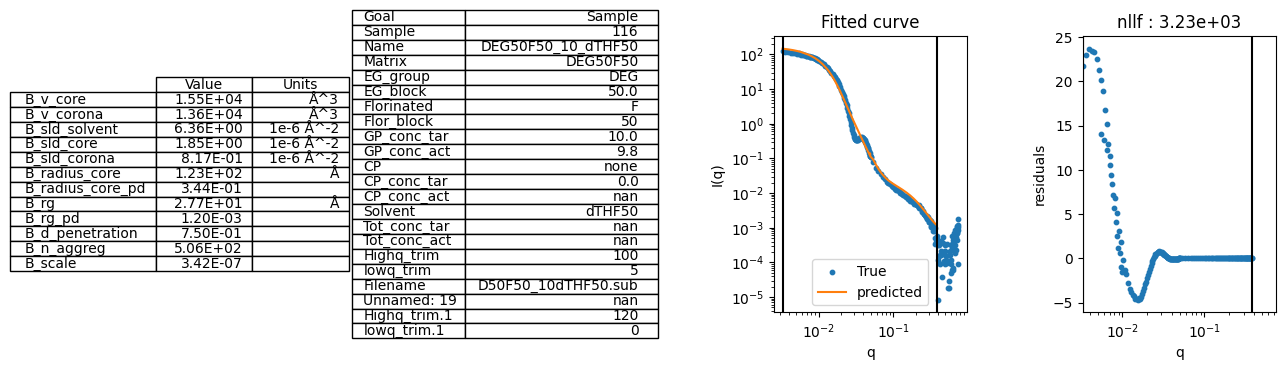

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F50_10dTHF75.sub'


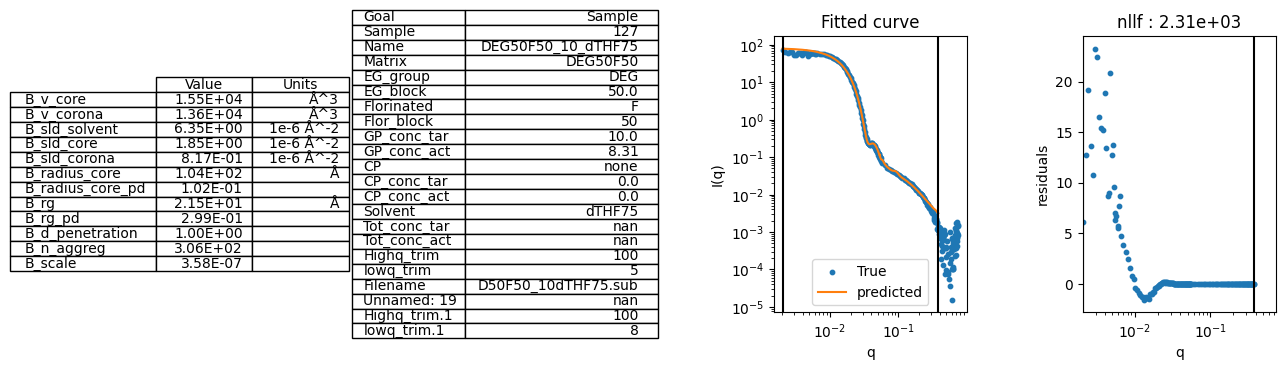

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F50_10dTol.sub'


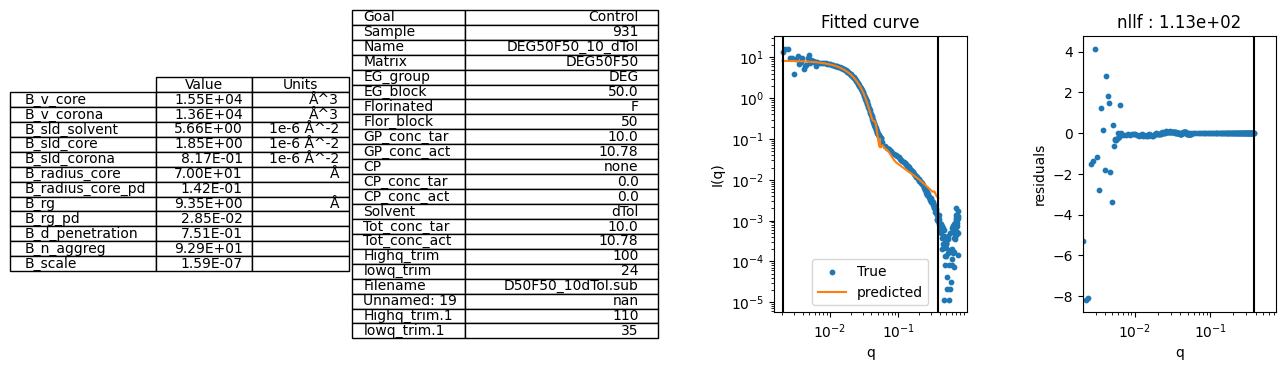

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F75_10dTHF50.sub'


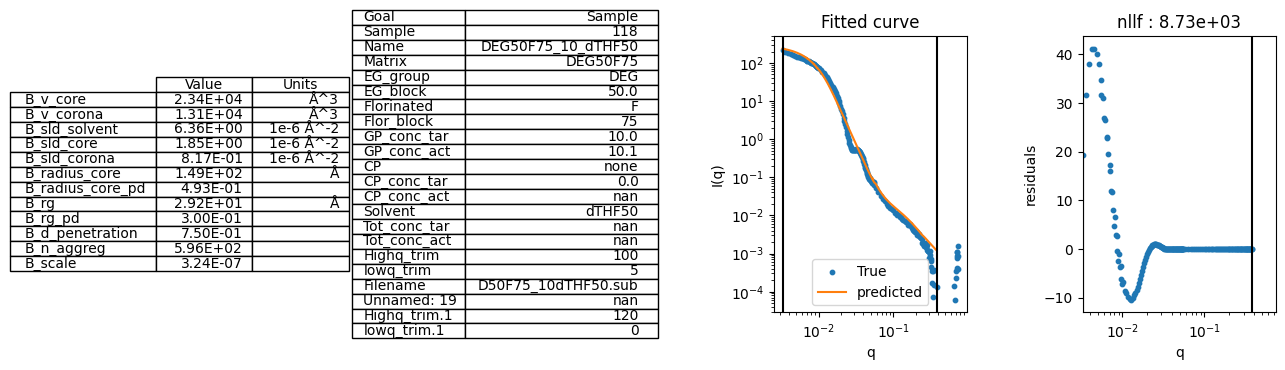

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F75_10dTHF75.sub'


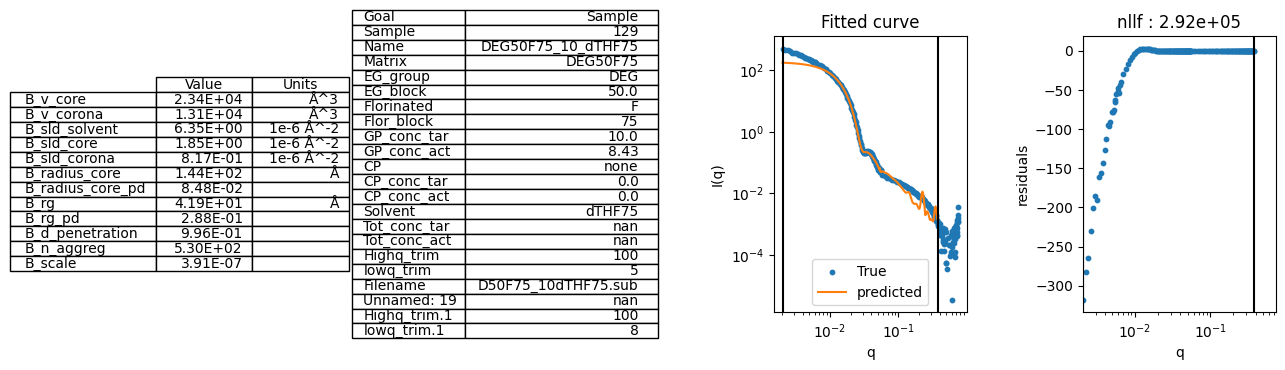

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F75_10dTol.sub'


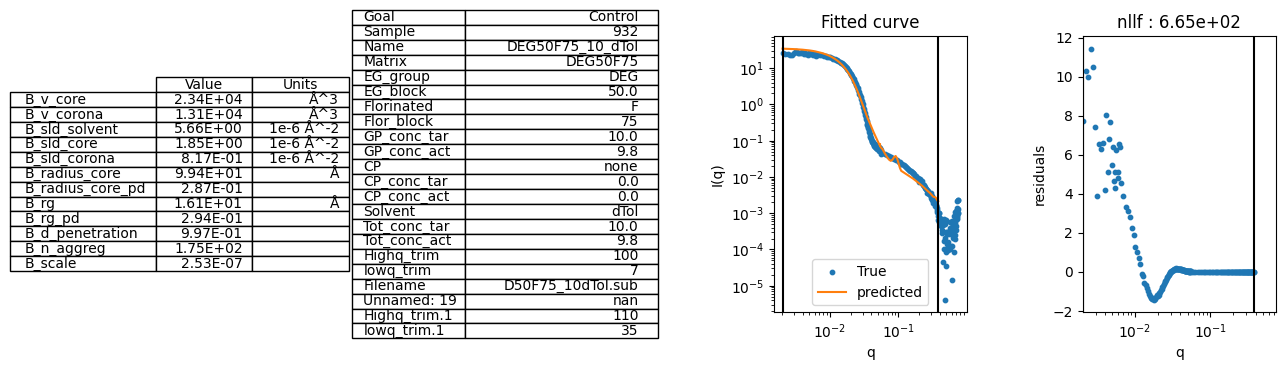

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F25_10dTHF25.sub'


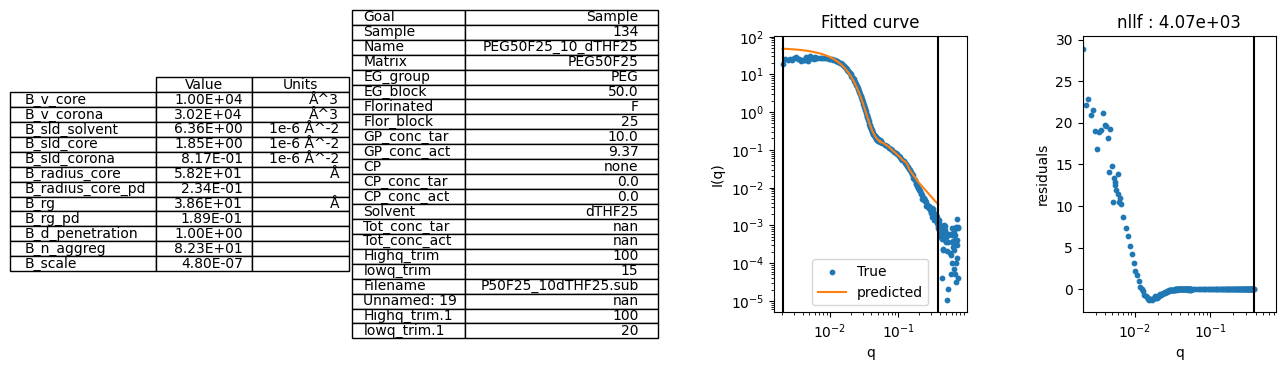

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F25_10dTHF50.sub'


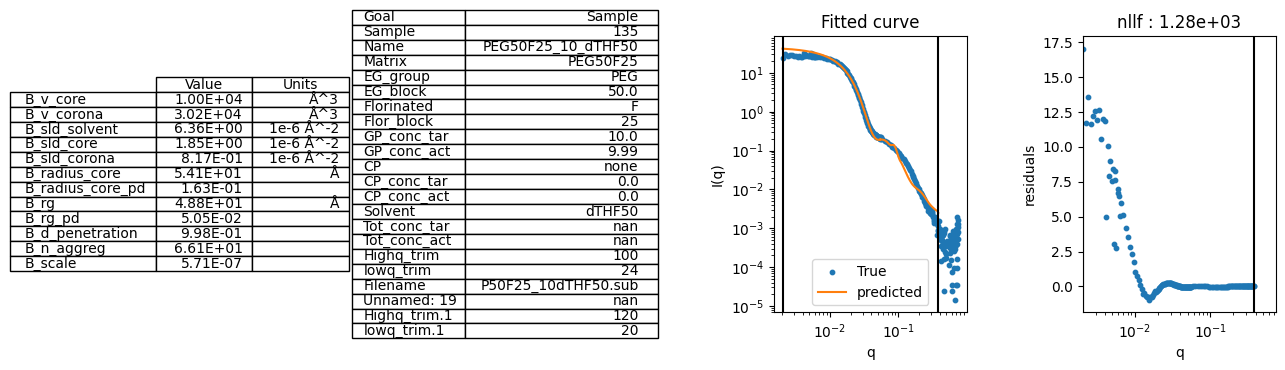

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F25_10dTHF75.sub'


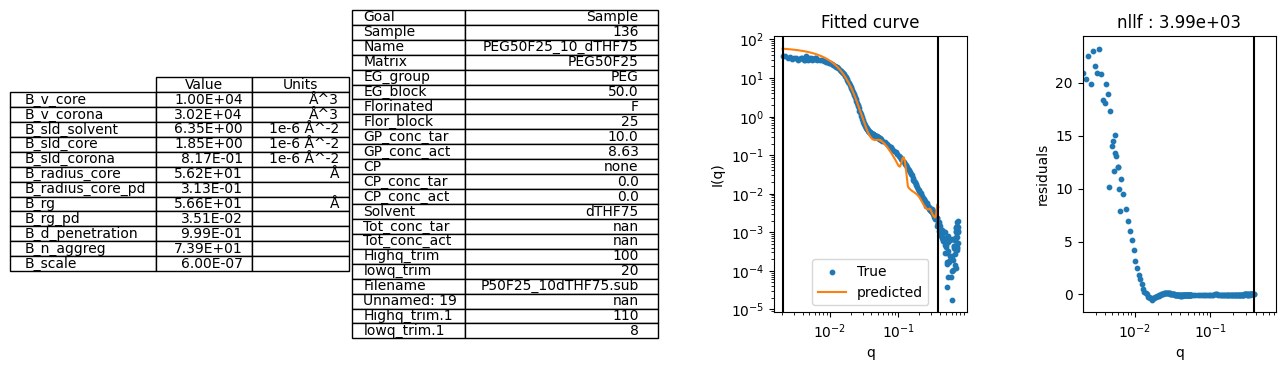

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F25_1dTHF50.sub'


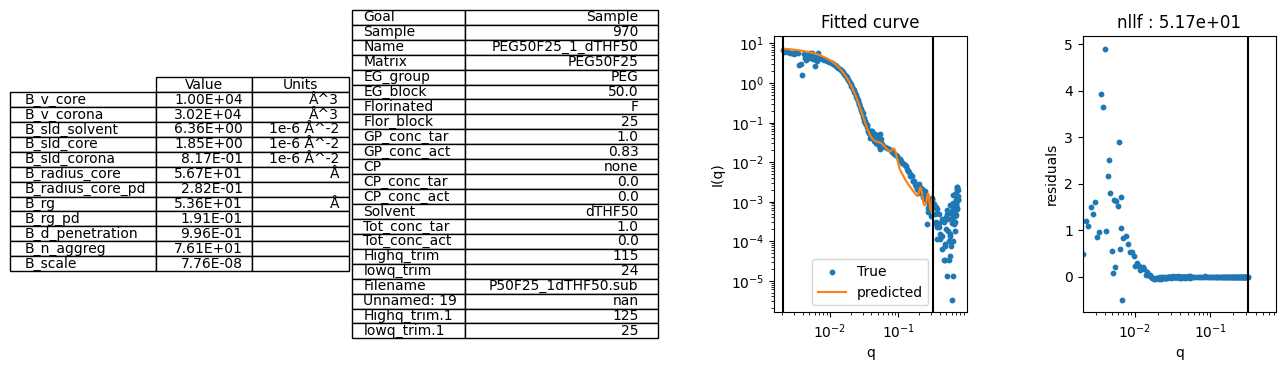

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F25_5dTHF50.sub'


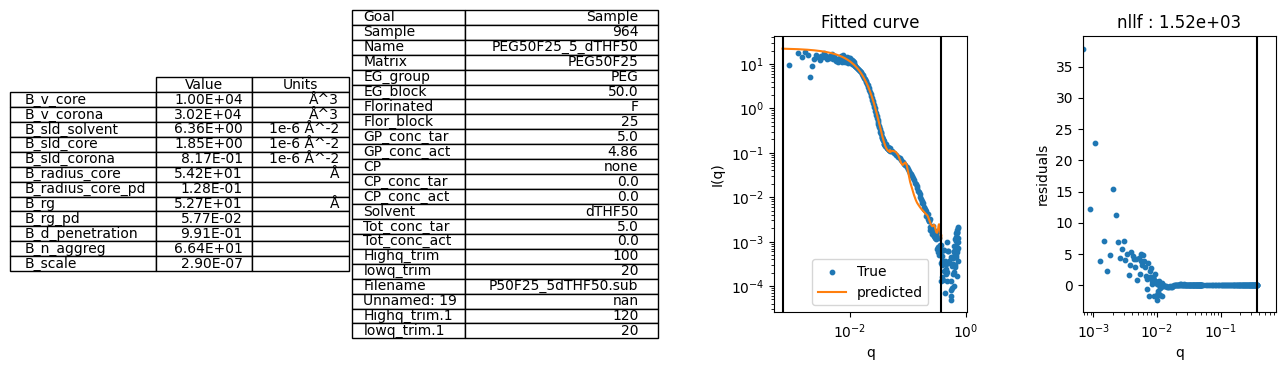

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F50_10dTHF25.sub'


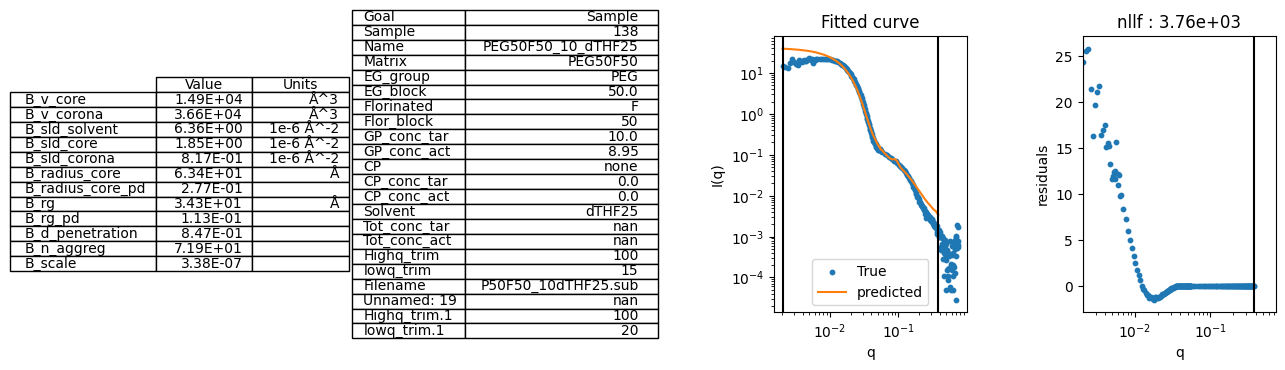

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F50_10dTHF50.sub'


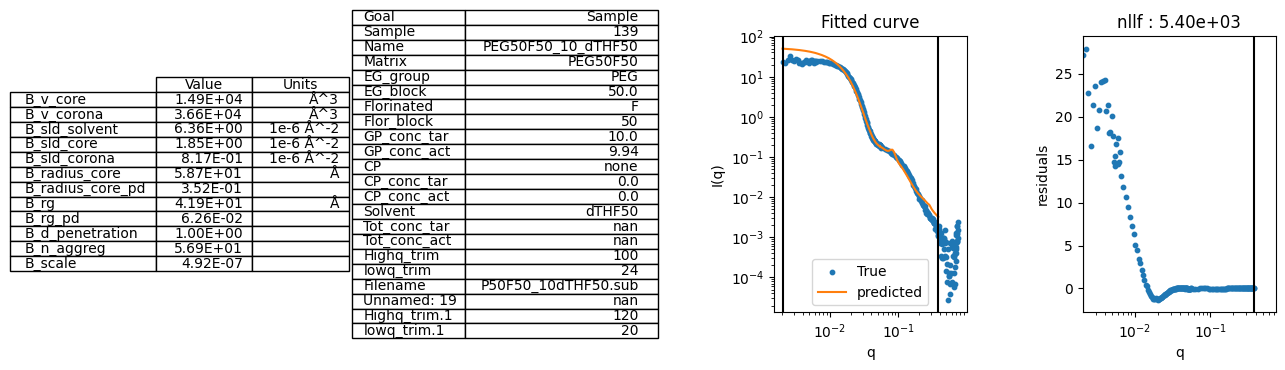

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F50_10dTHF75.sub'


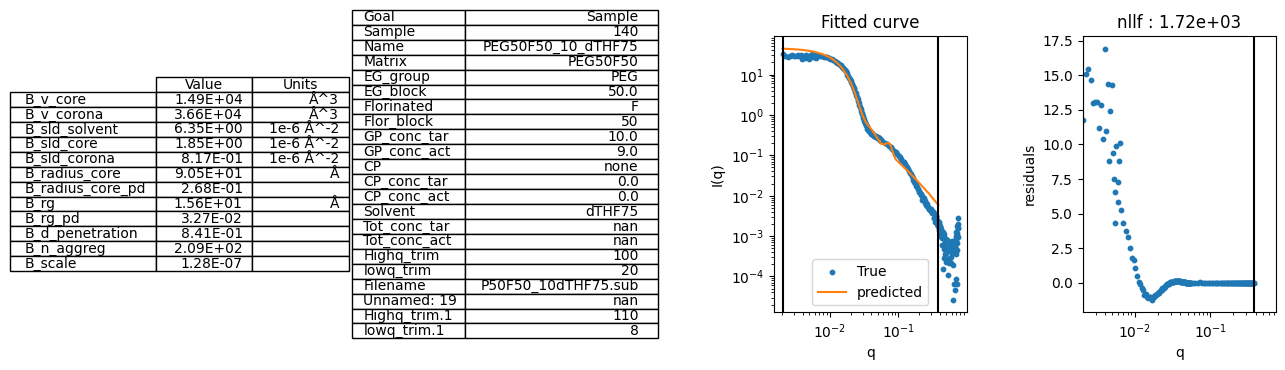

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F50_1dTHF50.sub'


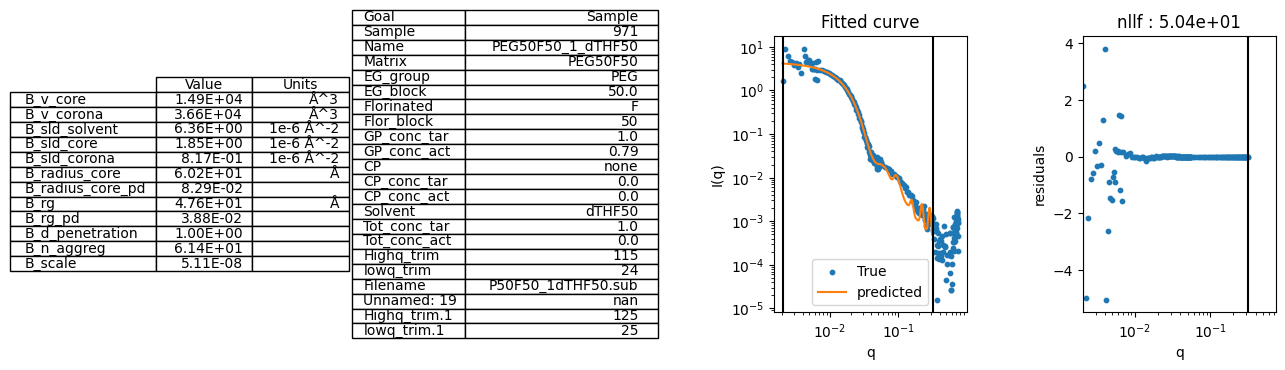

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/P50F50_5dTHF50.sub'


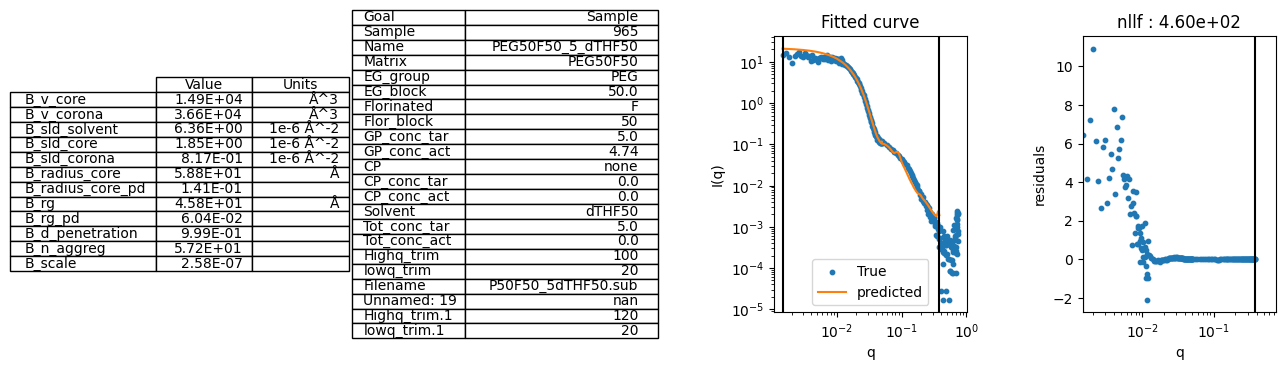

In [34]:
files = glob.glob(DATA_DIR+"*.json")
fnames = [f.split('/')[-1].split('.')[0] for f in files]

for fname in sorted(fnames):
    plot(fname)
    plt.show()